# Банки — Анализ оттока клиентов

**Презентация:**<https://disk.yandex.ru/i/7Hdi788WbWk7_Q>

В банке «Метанпром» последнее время драматически повысился отток клиент, это становиться проблемой, которая угрожает существованию банка. В связи с этим менеджеры отдела маркетинга заказали проанализировать клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка.

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Исследование будет проводиться в несколько этапов:
- Шаг 1. Загрузка, первичный осмотр и предобработка данных;
- Шаг 2. Исследовательский анализ данных;
- Шаг 3. Сегментация клиентов банка и определение портретов клиентов, которые склонны уходить из банка;
- Шаг 4. Проверка статистических гипотез:
  - гипотеза 1: *доход клиентов, которые ушли и тех, которые остались, различается*,
  - гипотеза 2: *доли клиентов, ушедших из банка, среди активных и неактивных клиентов различаются*;
- Шаг 5. Формулирование выводов по работе.

### Загрузка, первичный осмотр и предобработка данных

In [509]:
import pandas as pd
pd.set_option('display.max_columns', 0)
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
from scipy import stats as st
import numpy as np
import math as mth
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [510]:
# чтение файла bank_scrooge.csv с данными и сохранение его в переменную
path = "..."
df = pd.read_csv(path)

In [511]:
# изучаем первые 10 строк датасета
df.head(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


In [512]:
# изучаем общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


В датасете 12 колонок и 10000 строк. Колонки `USERID` и `EST_SALARY` нужно переименовать. Типы данных в датасете соотвествуют значениям, оставим их без изменения. Проверим наличие полных дубликатов в датасете и наличие дубликатов в колонке с идентификатором пользователя. В колонке `balance` есть пропуски, изучим их.

In [513]:
# переименуем столбцы
df = df.rename(columns = {'USERID' : 'user_id', 'EST_SALARY' : 'salary'})

# проверим
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'salary', 'churn'],
      dtype='object')

In [514]:
# проверим наличие полных дубликатов
print('Количество дубликатов =', df.duplicated().sum())

Количество дубликатов = 0


In [515]:
# избавимся от дубликатов и проверим еще раз
df = df.drop_duplicates()
print('Количество оставшихся дубликатов =', df.duplicated().sum())

Количество оставшихся дубликатов = 0


In [516]:
# проверим наличие дубликатов в столбце user_id
print('Количество дубликатов в столбце user_id =', df['user_id'].duplicated().sum())

Количество дубликатов в столбце user_id = 73


Дубликаты в столбце user_id составляют меньше 1% от общего числа записей в датасете, можем удалить их без вреда для исследования.

In [517]:
# удалим дубликаты в столбце user_id и еще раз проверим
df = df.drop_duplicates(subset=['user_id'])
print('Количество оставшихся дубликатов в столбце user_id =', df['user_id'].duplicated().sum())

Количество оставшихся дубликатов в столбце user_id = 0


In [518]:
# изучим пропуски в столбце balance
print('Количество пропусков в столбце balance = ', len(df[df['balance'].isna()]))

Количество пропусков в столбце balance =  2260


Удалить пропуски из датасета мы не можем, так мы потеряем 22.8% записей. Заполнить медианой или средним такие пропуски мы тоже не можем, столбец balance содержит информацию о балансе на счете клиента, такая инофрмация строго индивидуальна для каждого клиента. Нам остается только оставить эти пропуски в том виде, в котором они есть. 

In [519]:
# присвоим новый индекс записям в датасете
df = df.reset_index(drop=True)

In [520]:
# еще раз посмотрим на датасет
df.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


In [521]:
# и изучим информацию о нем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9927 entries, 0 to 9926
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9927 non-null   int64  
 1   score          9927 non-null   float64
 2   city           9927 non-null   object 
 3   gender         9927 non-null   object 
 4   age            9923 non-null   float64
 5   equity         9927 non-null   int64  
 6   balance        7667 non-null   float64
 7   products       9927 non-null   int64  
 8   credit_card    9927 non-null   int64  
 9   last_activity  9927 non-null   int64  
 10  salary         9927 non-null   float64
 11  churn          9927 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 930.8+ KB


**На этапе предобработки данных** мы избавились от проблем в названии столбцов, избавились от дубликатов и изучили пропуски в датасете.
<br>По результатам предобработки в таблице 12 столбцов и 9927 строк. В столбце balance 2260 необрабатываемых пропусков.

Первичный осмотр и предобработка данных заверешены, можем приступать к исследовательскому анализу данных.

### Исследовательский анализ данных

На данном этапе изучим географической положение клиентов банка, их разделение по полу, возрасту, доходу и другим показателям. 

Изучим географию клиентов. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск, посчитаем сколько клиентов в каждом городе.

In [522]:
# найдем количество клиентов банка в каждом городе
city = df['city'].value_counts().reset_index()
city.columns = ['city', 'count']
city

,city,count
0,Ярославль,5856
1,Рыбинск,2654
2,Ростов,1417


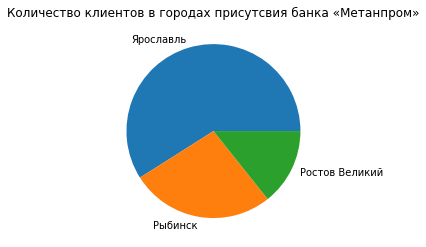

In [523]:
# посторим круговую диаграмму с количеством клиентов по городам
labels = ['Ярославль', 'Рыбинск', 'Ростов Великий']
city_pie = [5856, 2654, 1417]  

fig, ax = plt.subplots() 
ax.pie(city_pie, labels = labels) 
ax.set_title('Количество клиентов в городах присутсвия банка «Метанпром»') 
plt.show();

In [524]:
# найдем количество мужчин и женщин среди клиентов
gender = df['gender'].value_counts().reset_index()
gender.columns = ['gender', 'count']
gender

,gender,count
0,М,4972
1,Ж,4955


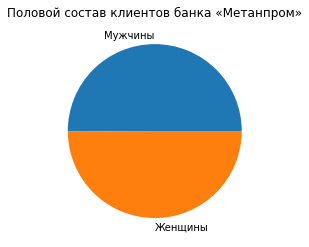

In [525]:
# построим круговую диаграмму
labels = ['Мужчины', 'Женщины']
gender_pie = [4972, 4955]  

fig, ax = plt.subplots() 
ax.pie(gender_pie, labels = labels) 
ax.set_title('Половой состав клиентов банка «Метанпром»') 
plt.show();

In [526]:
# создадим функцию для присвоения возрастной категории
def age_group(age):
    if age >= 18 and age <= 25:
        return '18-25'
    if age >= 26 and age <= 30:
        return '26-30'
    if age >= 31 and age <= 35:
        return '31-35'
    if age >= 36 and age <= 40:
        return '36-40'
    if age >= 41 and age <= 45:
        return '41-45'
    return '45+' 

In [527]:
# добавим в таблицу столбец с возрастными категориями
df['age_group'] = df['age'].apply(age_group)
df.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_group
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,18-25
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,36-40
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,26-30
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,45+
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,31-35
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,45+
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,36-40
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,36-40
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0,45+
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,45+


Функция работает корректно, теперь узнаем количество клиентов каждой возрастной группы. Для этого напишем функцию bar_chart, которая будет считать количество клиентов по нужному нам параметру и строить столбчатую диаграмму по этим данным.

In [529]:
def bar_chart(dt, group1, group2, title, x_title, y_title):
    table = dt.groupby(group1)[group2].count().reset_index()
    table.columns = [group1, 'count']
    table = table.sort_values(['count'])
    
    plt.figure(figsize=(15, 5))

    sns.barplot(x=group1, y='count', data=table)

    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    plt.show()

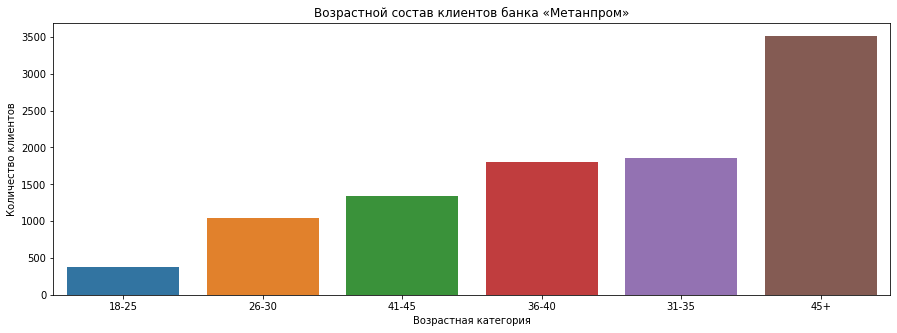

In [530]:
# применяем функцию bar_chart, чтобы найти количесвто клиентов в каждой возрастной категории
bar_chart(df, 'age_group', 'user_id',
         'Возрастной состав клиентов банка «Метанпром»', 'Возрастная категория', 'Количество клиентов')

Наиболее многочисленная группа клиентов - это клиенты старше 45 лет, меньше всего клиентов возрасте 18-25 лет. 
<br> Посмотрим, как делятся клиенты разных возрастов по полу. Для этого напишем еще одну функцию combined_bar_chart, она похожа на bar_chart, но теперь функция группирует данные не по одному, а по двум параметрам.

In [532]:
def combined_bar_chart(dt, cbc_group1, cbc_group2, cbc_group3, cbc_title, cbc_xtitle, cbc_ytitle):
    cbc_table = dt.groupby([cbc_group1, cbc_group2]).agg({cbc_group3 : 'count'})
    cbc_table = cbc_table.sort_values(cbc_group1).reset_index()
    cbc_table = cbc_table.rename(columns={cbc_group3:'count'})
    
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x='count',
            y=cbc_group1,
            hue=cbc_group2,
            data=cbc_table,
)

    ax.set_title(cbc_title)
    ax.set(xlabel=cbc_xtitle, ylabel=cbc_ytitle);

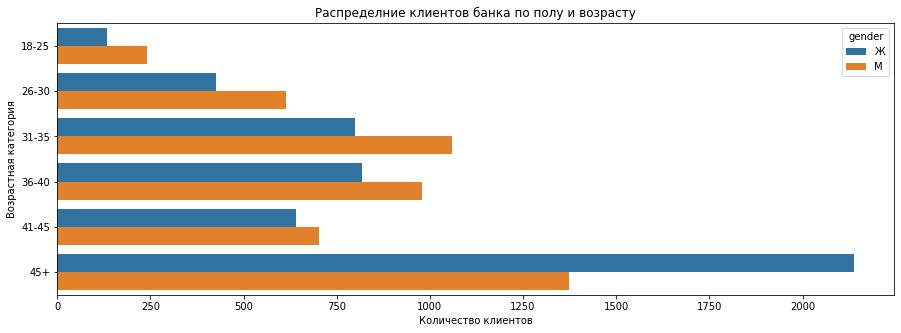

In [533]:
# найдем, как делятся клиенты по полу и возрасту и построим графикс помощью функции combined_bar_chart
combined_bar_chart(df, 'age_group', 'gender', 'user_id',
                  'Распределние клиентов банка по полу и возрасту',
                  'Количество клиентов', 'Возрастная категория')

Наиболее многочисленной категорией клиентов банка являются женщины в возрасте старше 45 лет. Среди клиентов старше 45 лет преобладает количество женщин, это единственная возрастная категория с подобным половым разделением, в остальных категориях преобладают мужчины. Реже всего среди клиентов встречаются женщины в возрасте 18-25 лет.

Рассмотрим, как распределяются доходы клиентов банка. Для этого, на основании столбца с заработной платой, выделим категории дохода и добавим их в отдельный столбец `income_level`, значения в новом столбце указаны в тысячах рублей.

In [534]:
# создадим функцию для присвоения категории дохода
def income_level(salary):
    if salary < 50000:
        return '>50'
    if salary > 50000 and salary <= 100000:
        return '50-100'
    if salary > 100000 and salary <= 150000:
        return '100-150'
    if salary > 150000 and salary <= 200000:
        return '150-200'
    if salary > 20000 and salary <= 300000:
        return '200-300'
    return '300+' 

In [535]:
# добавим в таблицу столбец с категориями дохода
df['income_level'] = df['salary'].apply(income_level)
df.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_group,income_level
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,18-25,50-100
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,36-40,50-100
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,26-30,100-150
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,45+,150-200
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,31-35,50-100
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,45+,150-200
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,36-40,100-150
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,36-40,50-100
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0,45+,150-200
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,45+,200-300


Функция работает. Изучим сколько клентов в кажой категории, для этого воспользуемся функцией bar_chart.

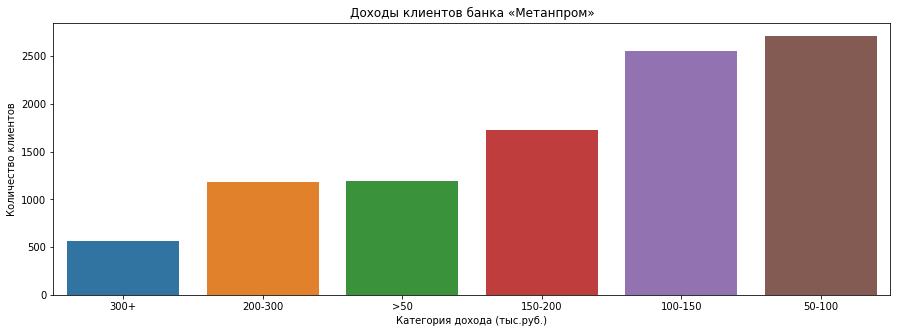

In [536]:
# применяем функцию bar_chart, чтобы найти количесвто клиентов по категориям дохода
bar_chart(df, 'income_level', 'user_id',
         'Доходы клиентов банка «Метанпром»', 'Категория дохода (тыс.руб.)', 'Количество клиентов')

Наиболее многочисленные категории клиентов с доходом 50-100 и 100-150 тыс.руб. Меньше всего клиентов банка с доходом более 300 тыс.руб. 
<br>Посмотрим как распределяются уровни дохода по возрасту и полу.

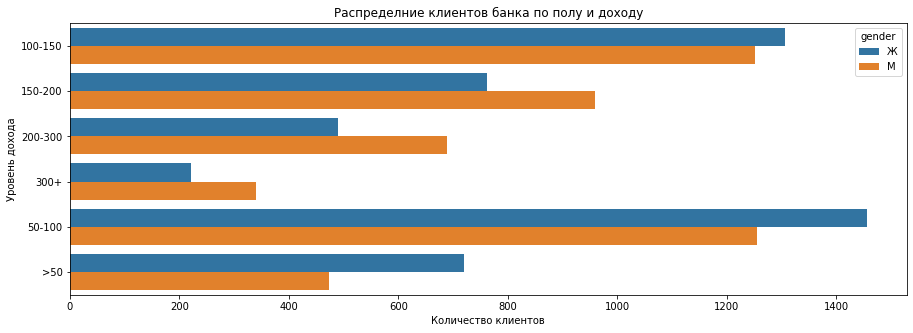

In [537]:
# используем функцию combined_bar_chart чтобы узнакть как распределяется доход клиентов в зависимости от пола
combined_bar_chart(df, 'income_level', 'gender', 'user_id',
                  'Распределние клиентов банка по полу и доходу',
                  'Количество клиентов', 'Уровень дохода')

На графике видим, что среди клиентов с доходом до 100 тыс.руб. преобладают женщины, в категории дохода 100-150 тыс.руб. примерно одинаковое количество клиентов обоих полов, а вот в категориях клиентов с доходом более 150 тыс.руб. преобладают мужчины. В целом, доход мужчин выше, чем доход женщин. 
<br>Изучим, как распределяются доход клиентов в зависимости от возраста.

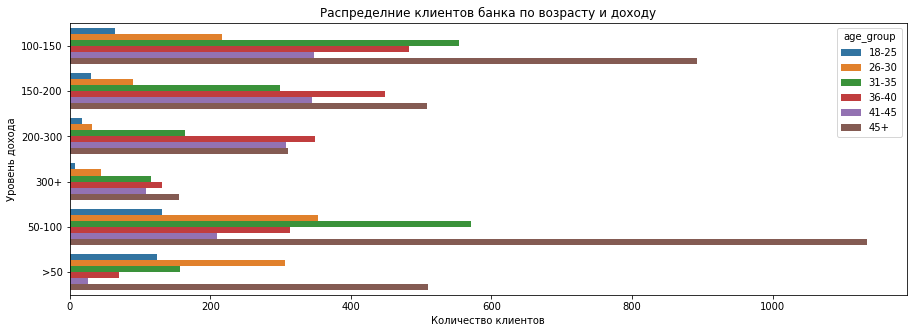

In [538]:
# используем функцию combined_bar_chart чтобы узнакть как распределяется доход клиентов в зависимости от возраста
combined_bar_chart(df, 'income_level', 'age_group', 'user_id',
                  'Распределние клиентов банка по возрасту и доходу',
                  'Количество клиентов', 'Уровень дохода')

По графику можно сделать следующие выводы:
- среди клиентов в возрасте 18-25 лет уровень дохода, как правило, не превышет 150 тыс.руб.;
- доход клиентов в возрасте 26-30 лет,  как правило, не превышает 200 тыс.руб., однако есть клиенты с доходом более 200-300 тыс.руб.;
- основная масса клиентов в возрасте 31-35 лет имеет доход в пределах 50-200 тыс.руб., при этом часть клиентов имеет меньший или больший доход;
- среди людей 36-40 лет большое количество клиентов с доходом 100-200 тыс.руб., также в категории дохода 200-300 тыс.руб. клиенты данного возраста наиболее многочисленны, по сравнению с клиентами других возрастов;
- доход клиентов в возрасте 41-45 лет находится в пределах 100-300 тыс.руб., при этом среди клиентов с доходом менее 100тыс.руб. данная возрастная категория встречается реже остальных;
- клиенты в возрасте старше 45 лет пробладают в категориях с доходом 50-150 тыс.руб., в то же время, среди людей с доходом менее 50 тыс.руб. и более 300тыс.руб. также много людей старше 45 лет.


**По итогам исследовательского анализа данных:**
- 59.1% из 9927 клиентов банка находятся в Ярославле, в Рыбинске находится 26.6% клиентов, наименьшее число клиентов в Ростове - 14.3%;
- в банке примерно одинаковое количесвто мужчин и женщин;
- наиболее многочисленная группа клиентов - это клиенты старше 45 лет, меньше всего клиентов возрасте 18-25 лет;
- среди клиентов старше 45 лет преобладает количество женщин, это единственная возрастная категория с подобным половым разделением, в остальных категориях преобладают мужчины, реже всего среди клиентов встречаются женщины в возрасте 18-25 лет;
- наиболее многочисленные категории клиентов с доходом 50-100 и 100-150 тыс.руб., меньше всего клиентов банка с доходом более 300 тыс.руб.;
- в целом, доход мужчин выше, чем доход женщин;
- как правило, доход клиентов в возрасте до 25 лет не превышает 150 тыс.руб., вместе с этим прослеживается тенденция к увелечению дохода с увелечением возраста, но эта тенденция не универсальна: так, значительная часть клиентов старше 45 лет имеет доход менее 50 тыс.руб.;

Исследовательский анализ данных завершен, приступим к сегментации отточных клиентов.

### Сегментация клиентов банка и определение портретов клиентов, которые склонны уходить из банка

Изучим клиентов, ушедших из банка: посчитаем их количество, проследим влияние различных параметров на уход из банка. <br>Столбец `churn` содержит информацию о том ушел клиент или нет:
- 1 - ушел,
- 0 - остался.

In [539]:
churn = len(df[df['churn'] == 1])
print('Количество клиентов, ушедших из банка =', churn)

Количество клиентов, ушедших из банка = 1820


Из банка ушло 18.3% клиентов. Изучим половой и возрастной состав отточных клиентов, узнаем в каком городе самое большое количество отточных клиентов. Также проследим влияет ли наличие нескольких продуктов банка или доход клиента на его уход. 

In [540]:
# перенесем информацию об ушедших клиентах в отдельный датасет
df_churn = df[df['churn'] == 1]
df_churn = df_churn.reset_index(drop=True)
df_churn.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_group,income_level
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,18-25,50-100
1,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,45+,150-200
2,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,31-35,50-100
3,132970,845.0,Ярославль,Ж,31.0,3,591928.52,2,1,1,112697.16,1,31-35,100-150
4,129705,811.0,Рыбинск,М,34.0,2,129799.35,1,0,0,96242.71,1,31-35,50-100
5,210764,748.0,Рыбинск,М,46.0,2,182889.96,1,1,1,74009.18,1,45+,50-100
6,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1,36-40,200-300
7,136096,896.0,Ярославль,Ж,39.0,5,657597.09,2,0,1,266033.98,1,36-40,200-300
8,156677,873.0,Ярославль,М,39.0,5,915959.85,3,0,1,154034.62,1,36-40,150-200
9,155403,859.0,Рыбинск,М,56.0,5,652553.80,2,1,1,60791.77,1,45+,50-100


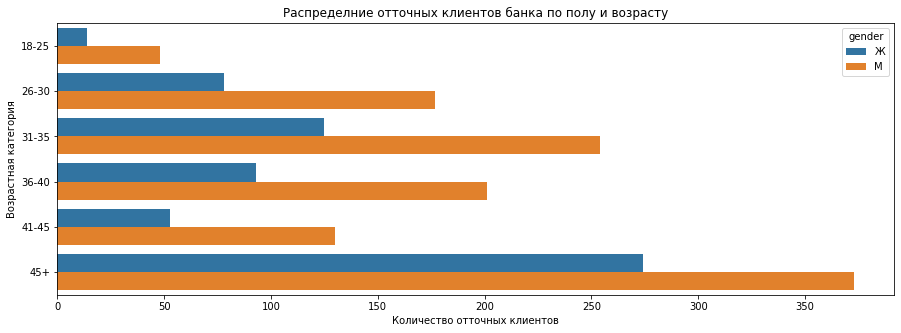

In [541]:
# найдем, как делятся отточные клиенты по полу и возрасту, используем функцию combined_bar_chart
combined_bar_chart(df_churn, 'age_group', 'gender', 'user_id',
                  'Распределние отточных клиентов банка по полу и возрасту',
                  'Количество отточных клиентов', 'Возрастная категория')

Наиболее склонны к уходу из банка клиенты в возрасте старше 45 лет. Среди всех возрастных групп отточных клиентов преобладают мужчины.
<br>Посмотрим, как распределяются отточные клиенты по полу и доходу.

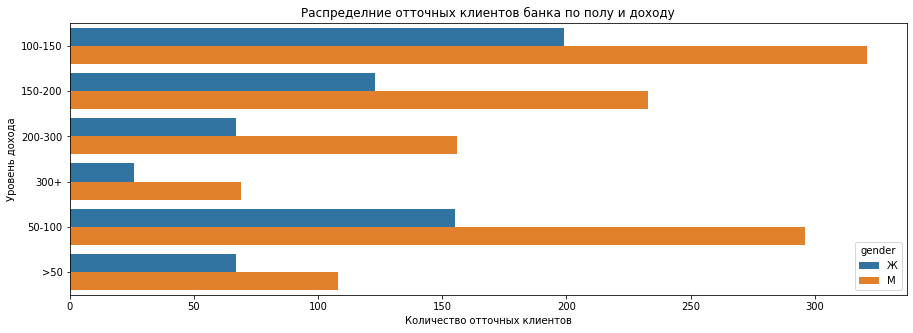

In [542]:
# найдем, как делятся отточные клиенты по полу и возрасту, используем функцию combined_bar_chart
combined_bar_chart(df_churn, 'income_level', 'gender', 'user_id',
                  'Распределние отточных клиентов банка по полу и доходу',
                  'Количество отточных клиентов', 'Уровень дохода')

Наибольшая склонность к уходу из банка прослеживается у клиентов с доходом 100-150 тыс.руб. Наименее склонны уходить из банка клиенты с доходом более 300 тыс.руб.
<br>Посомтрим, в каком городе наибольшее количесвто отточных клиентов.

In [543]:
# посчитаем количество отточных клиентов по городам и посторим круговую диаграмму
city_churn = df_churn['city'].value_counts().reset_index()
city_churn.columns = ['city', 'count']
city_churn

,city,count
0,Ярославль,1117
1,Рыбинск,437
2,Ростов,266


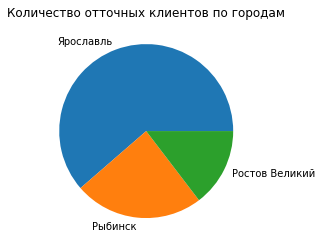

In [544]:
# построим круговую диаграмму
labels = ['Ярославль', 'Рыбинск', 'Ростов Великий']
city_churn_pie = [1117, 437, 266]   

fig, ax = plt.subplots() 
ax.pie(city_churn_pie, labels = labels) 
ax.set_title('Количество отточных клиентов по городам') 
plt.show();

Почти 60% клиентов, которые ушли из банка, находятся в Ярославле.
<br>Посмотрим, сколькими продуктами банка пользовались ушедшие клиенты.

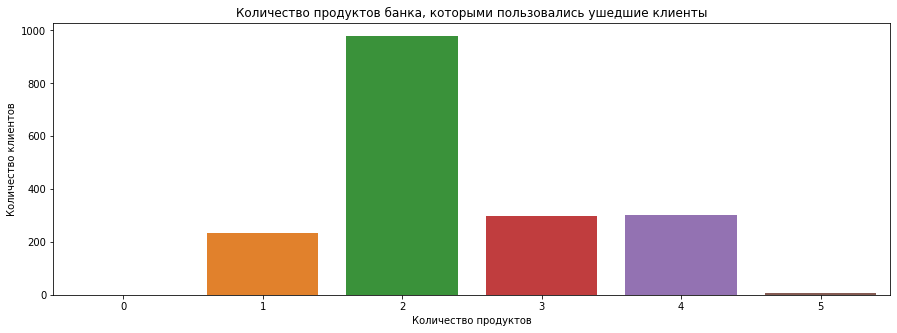

In [545]:
# используем функцию bar_chart
bar_chart(df_churn, 'products', 'user_id',
         'Количество продуктов банка, которыми пользовались ушедшие клиенты', 'Количество продуктов', 'Количество клиентов')

Больше половины отточных клиентов пользовались двумя продуктами банка.
<br> Проследим активность ушедших клиентов на основании столбца `last_activity`, где:
- 1 - был активен,
- 0 - не был ативен.

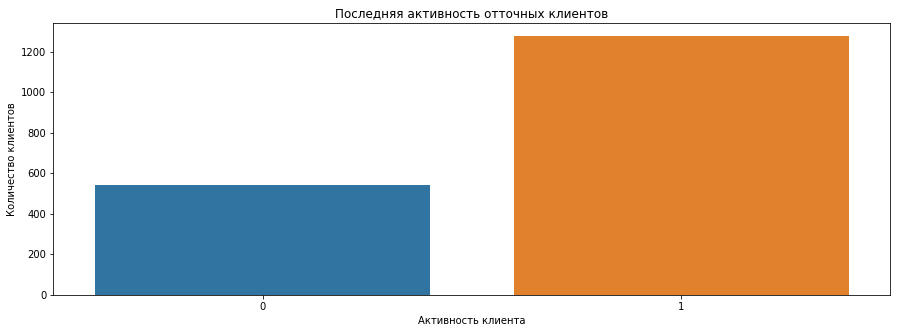

In [546]:
# используем функцию bar_chart
bar_chart(df_churn, 'last_activity', 'user_id',
         'Последняя активность отточных клиентов', 'Активность клиента', 'Количество клиентов')

Клиенты, покинувшие банк, в 70% случаев были ативны в последнее время.
<br>Посмотрим, у скольких клиентов была кредитная карта, на основании столбца `credit_card`, где:
- 1 - есть кредитная карта,
- 0 - нет карты.

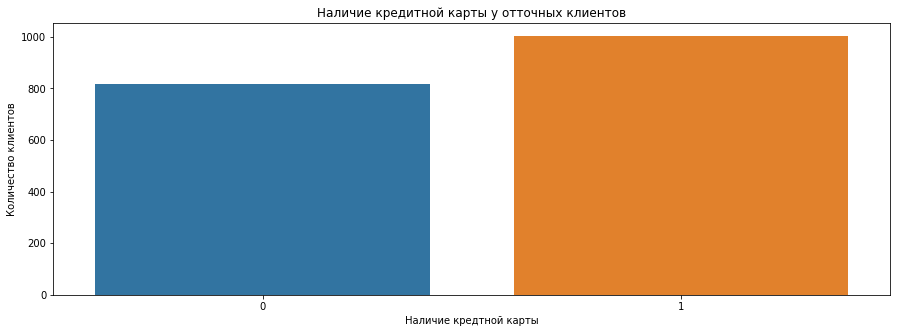

In [547]:
# используем функцию bar_chart
bar_chart(df_churn, 'credit_card', 'user_id',
         'Наличие кредитной карты у отточных клиентов', 'Наличие кредтной карты', 'Количество клиентов')

У 55% клиентов ушедших из банка была кредитная карта.
<br>Построим матрицу корреляций, чтобы проверить как взаимосвязанны различные факторы и уход улиента из банка. Матрицу будем сторить на основании исходного датасета, но не будем учитывать записи с пропусками в столбце `balance`.

interval columns not set, guessing: ['user_id', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'churn']


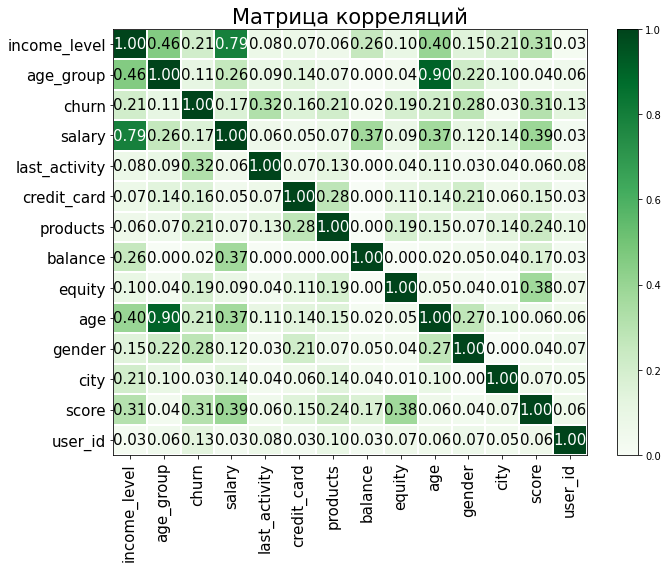

In [548]:
phik_overview = df.query('balance > 0').phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляций", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout();

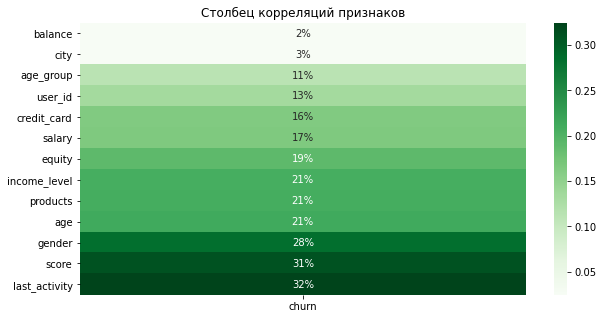

In [549]:
# выделеим отдельно колонку для удобства
plt.figure(figsize=(10, 5))
plt.title('Столбец корреляций признаков')
sns.heatmap(phik_overview.loc[:,['churn']].drop('churn').sort_values('churn'),
    annot=True,
    fmt='.0%',
    cmap='Greens'
)
plt.show()

Явной взаимосвязи между какими-либо параметрами и уходом клиента не выявлено: корреляция очень слабая или отсутствует вовсе.

Приступим к сегментированию клиентов. Выделим 4 группы клиентов:
- группа 1 - мужчины с доходом до 150 тыс.руб.;
- группа 2 - женщины с доходом до 150 тыс.руб.;
- группа 3 - мужчины с доходом более 150 тыс.руб.;
- группа 4 - женщины с доходом более 150 тыс.руб.

Распределим клиентов по группам, затем посчитаем количество в каждой из них, найдем сколько клиентов ушло или осталось в банке.

In [550]:
# формируем 1 группу: мужчины с доходом до 150 тыс.руб.
group_1 = df[(df.gender == 'М') & (df.salary <= 150000)]
group_1 = group_1.reset_index(drop=True)
group_1.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_group,income_level
0,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,31-35,50-100
1,172138,815.0,Ярославль,М,35.0,5,547499.87,2,1,1,105883.26,0,31-35,100-150
2,114192,772.0,Ростов,М,43.0,3,1315511.65,2,0,0,143935.71,0,41-45,100-150
3,161656,871.0,Ярославль,М,51.0,4,708866.92,1,1,0,106407.26,0,45+,100-150
4,167316,766.0,Ярославль,М,36.0,1,250543.82,2,1,1,38843.00,0,36-40,>50


In [551]:
# формируем 2 группу: женщины с доходом до 150 тыс.руб.
group_2 = df[(df.gender == 'Ж') & (df.salary <= 150000)]
group_2 = group_2.reset_index(drop=True)
group_2.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_group,income_level
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,18-25,50-100
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,36-40,50-100
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,26-30,100-150
3,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,36-40,100-150
4,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,36-40,50-100


In [552]:
# формируем 3 группу: мужчины с доходом более 150 тыс.руб.
group_3 = df[(df.gender == 'М') & (df.salary >= 150000)]
group_3 = group_3.reset_index(drop=True)
group_3.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_group,income_level
0,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,45+,150-200
1,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0,45+,150-200
2,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,45+,150-200
3,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,41-45,200-300
4,120260,731.0,Рыбинск,М,42.0,3,1480548.47,3,1,0,160974.43,0,41-45,150-200


In [553]:
# формируем 4 группу: женщины с доходом более 150 тыс.руб.
group_4 = df[(df.gender == 'Ж') & (df.salary >= 150000)]
group_4 = group_4.reset_index(drop=True)
group_4.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_group,income_level
0,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,45+,150-200
1,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,45+,200-300
2,177415,896.0,Рыбинск,Ж,47.0,0,NaN,1,0,0,225060.35,0,45+,200-300
3,130826,898.0,Ярославль,Ж,39.0,5,561906.51,1,1,0,151221.69,0,36-40,150-200
4,155730,946.0,Ярославль,Ж,47.0,0,NaN,2,1,1,660015.85,0,45+,300+


In [554]:
# создадим функцию, которая будет подсчитывать общее количество клиентов в ней, количество клиентов, которые остались и ушли
# и процент ушедших от общего количества
def segment_indicators(group):
    table = group.pivot_table(columns='churn', values='user_id', aggfunc='count')
    table['total'] = group['user_id'].count()
    table.columns = ['0_churn', '1_churn', 'total']
    table['churn_%'] = (table['1_churn'] / table['total'] * 100).round(2)
    print(table)

In [555]:
# напишем цикл, который будет применять ко всем группам функцию segment_indicators
groups = [group_1, group_2, group_3, group_4]
n = 0

for group in groups:
    n = n+1
    print('группа', n)
    segment_indicators(group)
    print('')

группа 1
         0_churn  1_churn  total  churn_%
user_id     2256      725   2981    24.32

группа 2
         0_churn  1_churn  total  churn_%
user_id     3061      421   3482    12.09

группа 3
         0_churn  1_churn  total  churn_%
user_id     1533      458   1991     23.0

группа 4
         0_churn  1_churn  total  churn_%
user_id     1257      216   1473    14.66



Количество клиентов в группах не равномерно - наиболее многочисленна 2 группа - женщины с доходом до 150.тыс.руб., в ней же самый низкий процент оттока клиентов.

Больше всего отточных клиентов в первой группе - мужчины с доходом до 150 тыс.руб., также много клиентов, которые ушли из банка в третьей группе - мужчины с доходом более 150 тыс.руб.

**Среди клиентов ушедших из банка:**
- количество клиентов ушедших из банка - 1821, это составляет 18.3% от общего числа клиентов.
- почти 65% мужчин;
- 35% клиентов в возрасте старше 45 лет, меньше всего клиентов в возрасте 18-25 лет;
- 28.5% клиентов имеют доход 100-150 тыс.руб., 24.8% имеют доход 50-100 тыс.руб., наименьшее число клиентов с доходом более 300 тыс.руб.;
- 59.1% клиентов находятся в Ярославле;
- 53.7% клиентов пользовались двумя продуктами банка;
- 70% были ативны в последнее время;
- 55% имели кредитную карту.

Наиболее отточный сегмент - мужчины с доходом до 150 тыс.руб., при численности 2981, отток клиентов составляет 24.32%.

Приступим к проверке статистических гипотез.

### Проверка статистических гипотез

Предстоит проверить 2 гипотезы:
- гипотеза 1: *доход клиентов, которые ушли и тех, которые остались, различается*:
   - H₀ - доход клиентов, которые ушли и тех, которые остались, не различается,
   - H₁ - доход клиентов, которые ушли и тех, которые остались, различается;
- гипотеза 2: *доли клиентов, ушедших из банка, среди активных и неактивных клиентов различаются*:
   - H₀ - доли клиентов, ушедших из банка, среди активных и неактивных клиентов не различаются,
   - H₁ - доли клиентов, ушедших из банка, среди активных и неактивных клиентов различаются.
   
Приступим к проверке гипотезы 1, уровень критерия статистической значимости alpha примем 0.05.

In [556]:
# формируем выборки
sample_1 = df.query('churn == 0')['salary']
sample_2 = df.query('churn == 1')['salary']

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.9052061761558352
Не получилось отвергнуть нулевую гипотезу


In [557]:
# сравним относительную разницу средних:
print('Относительная разница средних', '{0:.2%}'.format(sample_2.mean() / sample_1.mean() - 1))

Относительная разница средних 0.29%


Нулевая гипотеза подтвердилась - доход клиентов, которые ушли и тех, которые остались, не различается. Относительная разница средних пренебрежимо мала, что подтверждает результаты теста.

Приступим к проверке гипотезы 2.

In [558]:
# формируем выборки
sample_1 = df.query('churn == 0')['last_activity']
sample_2 = df.query('churn == 1')['last_activity']

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 6.966842486812411e-65
Отвергаем нулевую гипотезу


In [559]:
print('Относительная разница средних', '{0:.2%}'.format(sample_2.mean() / sample_1.mean() - 1))

Относительная разница средних 45.26%


Нулевая гипотеза не подтвердилась, отвергеам ее. Доли клиентов, ушедших из банка, среди активных и неактивных клиентов различаются. Относительная разница средних существенна, что подтверждает результаты теста.

**По результатам проверки статистических гипотез:**
- доход клиентов, которые ушли и тех, которые остались, не различается;
- доли клиентов, ушедших из банка, среди активных и неактивных клиентов различаются.

### Общие выводы и рекомендации

В проекте предстояло проанализировать отток клиентов из банка «Метанпром».

На превом этапе избавились от проблем в названии столбцов, избавились от дубликатов и изучили пропуски в датасете. По результатам предобработки в таблице 12 столбцов и 9927 строк. В столбце balance 2260 необрабатываемых пропусков.

По результатам исследовательского анализа данных:
- 59.1% из 9927 клиентов банка находятся в Ярославле, в Рыбинске находится 26.6% клиентов, наименьшее число клиентов в Ростове - 14.3%;
- в банке примерно одинаковое количесвто мужчин и женщин;
- наиболее многочисленная группа клиентов - это клиенты старше 45 лет, меньше всего клиентов возрасте 18-25 лет;
- среди клиентов старше 45 лет преобладает количество женщин, это единственная возрастная категория с подобным половым разделением, в остальных категориях преобладают мужчины, реже всего среди клиентов встречаются женщины в возрасте 18-25 лет;
- наиболее многочисленные категории клиентов с доходом 50-100 и 100-150 тыс.руб., меньше всего клиентов банка с доходом более 300 тыс.руб.;
- в целом, доход мужчин выше, чем доход женщин;
- как правило, доход клиентов в возрасте до 25 лет не превышает 150 тыс.руб., вместе с этим прослеживается тенденция к увелечению дохода с увелечением возраста, но эта тенденция не универсальна: так, значительная часть клиентов старше 45 лет имеет доход менее 50 тыс.руб.;
- количество клиентов ушедших из банка - 1821, это составляет 18.3% от общего числа клиентов.

Количество клиентов ушедших из банка - 1821, это составляет 18.3% от общего числа клиентов. Явной взаимосвязи между какими-либо параметрами и уходом клиента не выявлено: корреляция очень слабая или отсутствует вовсе. 
<br>Среди клиентов, которые склонны уходить из банка:
- почти 65% мужчин;
- 35% клиентов в возрасте старше 45 лет, меньше всего клиентов в возрасте 18-25 лет;
- 28.5% клиентов имеют доход 100-150 тыс.руб., 24.8% имеют доход 50-100 тыс.руб., наименьшее число клиентов с доходом более 300 тыс.руб.;
- 59.1% клиентов находятся в Ярославле;
- 53.7% клиентов пользовались двумя продуктами банка;
- 70% были ативны в последнее время;
- 55% имели кредитную карту.

Наиболее отточный сегмент - мужчины с доходом до 150 тыс.руб., при численности 2981, отток клиентов составляет 24.32%. Самый низкий процент оттока клиентов в сегменте женщин с доходом до 150.тыс.руб.

Проверка статистических гипотез дала следующие результаты:
- доход клиентов, которые ушли и тех, которые остались, не различается;
- доли клиентов, ушедших из банка, среди активных и неактивных клиентов различаются.

Рекомендации отделу маркетинга дать сложно, так как прямой взаимосвязи с каким-либо парматером и уходом клиентов из банка не обнаружено. Однако, удалось выяснить что мужчины более склонны уходить из банка чем женщины, также выше отток клиентов с доходом 50-150 тыс.руб. и почти 60% отточных клиентов находятся в Ярославле. Наиболее отточный сегмент - мужчины с доходом до 150 тыс.руб. Стоит обратить внимание на эти группы клиентов и подготовить предложения, которые смогут заинтресовать проблемных клиентов, например, можно разработать систему лояльности, в которой будут учавствоать сети АЗС в Ярославле.